# **Predictive Modeling and Evaluation (Week 4)**

In [5]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Optional Advanced Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import joblib
import warnings
warnings.filterwarnings("ignore")


Step 2: Load Raw Dataset

Make sure your raw dataset (Telco_Customer_Churn.csv) is in the Week 4 folder.

In [7]:
# Load raw dataset
df = pd.read_csv("Telco-Customer-Churn.csv")

# Preview the data
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Step 3: Initial Exploration**

Check the structure of the dataset.

In [8]:
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())


Dataset Shape: (7043, 21)

Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing Values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract  

**Step 4: Data Cleaning**

We’ll handle missing values, incorrect data types, and duplicates.

4.1 Handle Missing Values

In [9]:
# Remove duplicate rows if any
df.drop_duplicates(inplace=True)

# Fill missing TotalCharges with MonthlyCharges * Tenure (if Tenure > 0)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'], inplace=True)


4.2 Drop Unnecessary Columns

In [10]:
# Drop irrelevant columns like customerID
df.drop(columns=['customerID'], inplace=True)


### **Step 5: Encode Categorical Variables**

We need to convert text columns to numbers for modeling.

In [11]:
# Identify categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_cols.tolist())

# One-Hot Encode categorical variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


Categorical Columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


**Step 6: Feature Scaling**

Standardize numerical features so that different scales don't bias the model.

In [12]:
# Identify numerical columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


**Step 7: Define Features and Target**

We’ll set up our X and y.

In [13]:
# Target is Churn_Yes (created after one-hot encoding)
y = df['Churn_Yes']
X = df.drop('Churn_Yes', axis=1)

# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)


Training Shape: (5634, 30)
Testing Shape: (1409, 30)


**Step 8: Baseline Model Training**

We’ll start with Logistic Regression and Decision Tree.

8.1 Logistic Regression

In [14]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1]))


Logistic Regression Performance:
Accuracy: 0.8062455642299503
Precision: 0.6593059936908517
Recall: 0.5588235294117647
F1 Score: 0.6049204052098408
ROC AUC: 0.8421788214627088


8.2 Decision Tree

In [15]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("\nDecision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1]))



Decision Tree Performance:
Accuracy: 0.7274662881476224
Precision: 0.4864864864864865
Recall: 0.48128342245989303
F1 Score: 0.4838709677419355
ROC AUC: 0.648353096179183


**Step 9: Advanced Models**

We now move to Random Forest, Gradient Boosting, XGBoost, and LightGBM.

9.1 Random Forest

In [16]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))



Random Forest Performance:
Accuracy: 0.7863733144073811
Precision: 0.6220735785953178
Recall: 0.49732620320855614
F1 Score: 0.5527488855869243
ROC AUC: 0.8248856854994963


9.2 Gradient Boosting

In [17]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

print("\nGradient Boosting Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb))
print("F1 Score:", f1_score(y_test, y_pred_gb))
print("ROC AUC:", roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1]))



Gradient Boosting Performance:
Accuracy: 0.7977288857345636
Precision: 0.6539792387543253
Recall: 0.5053475935828877
F1 Score: 0.5701357466063348
ROC AUC: 0.84165439561859


9.3 XGBoost

In [18]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("\nXGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))



XGBoost Performance:
Accuracy: 0.7721788502484032
Precision: 0.5830721003134797
Recall: 0.49732620320855614
F1 Score: 0.5367965367965368
ROC AUC: 0.8223836833811259


Step 10: Hyperparameter Tuning (Random Forest Example)

In [19]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


Step 11: Confusion Matrix & Classification Report

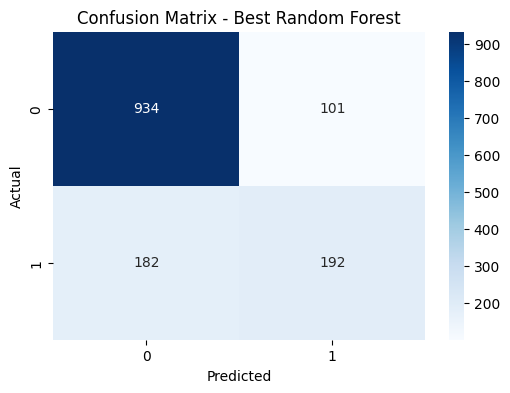


Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.90      0.87      1035
        True       0.66      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best Random Forest")
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))


Step 12: ROC Curve

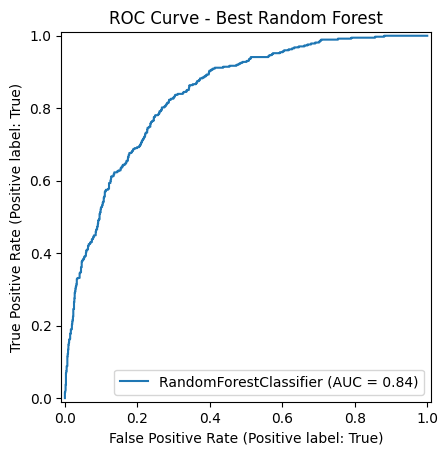

In [21]:
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve - Best Random Forest")
plt.show()


Step 13: Save Final Model

In [22]:
joblib.dump(best_rf, "final_churn_model.pkl")
print("Final model saved as final_churn_model.pkl")


Final model saved as final_churn_model.pkl
